[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedsalim3/id-fan-failure-prediction/blob/main/notebooks/main.ipynb)

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve)
import warnings, os, joblib

sns.set(style="white")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


In [2]:
# ======= CONFIG =======
if IN_COLAB:
    !wget https://gist.githubusercontent.com/ahmedsalim3/8f7e10dab88761f5f05412e49c841612/raw/97d850f7148f7ca59d28fdc77f0b5b0b309f1a54/ID%2520Fan%2520Trends%2520in%2520Excel.csv
    DATASET_PATH = "ID Fan Trends in Excel.csv"
    OUTPUT_PATH = "output"
    EDA_PATH = OUTPUT_PATH + "/eda"
    CKPT_PATH = OUTPUT_PATH + "/ckpts"
else:
    DATASET_PATH = "../data/ID Fan Trends in Excel.xlsx"
    OUTPUT_PATH = "../output"
    EDA_PATH = OUTPUT_PATH + "/eda"
    CKPT_PATH = OUTPUT_PATH + "/ckpts"
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(EDA_PATH, exist_ok=True)
os.makedirs(CKPT_PATH, exist_ok=True)

TRAIN_RATIO = 0.8 # (80% Train, 20% Test)
SEED = 42

## 1. Data Preperation

In [3]:
# load the dataset
if IN_COLAB:
    df = pd.read_csv(DATASET_PATH)
else:
    df = pd.read_excel(DATASET_PATH, sheet_name="Data", skiprows=2)
    df.to_csv(DATASET_PATH.replace(".xlsx", ".csv"))

display(df.head())
display(df.describe())

,date,time,Milliseconds,"WEIGHTED COAL FLOW, (t/h)","GENERATOR POWER, (MW)","MAIN STEAM FLOW, (t/h)","CONCENTRATION OF DUST, (mg/m3)","ID FAN B LUBE OIL STATION OUTLET DIRVE OIL PRESS., (Mpa)","ID FAN A VARIABLE BLADE POSITION, (%)","ID FAN B VARIABLE BLADE POSITION, (%)",...,"ID FAN A OUTLET FLUE GAS PRESS., (kPa)","ID FAN B INLET FLUE GAS PRESS., (kPa)","ID FAN B OUTLET FLUE GAS PRESS., (kPa)","ID FAN A INLET FLUE GAS TEMP., (℃)","ID FAN B INLET FLUE GAS TEMP., (℃)","ID FAN A BEARING X DIRECTION VIBRATION, (mm/S)","ID FAN A BEARING Y DIRECTION VIBRATION, (mm/S)","ID FAN B BEARING X DIRECTION VIBRATION, (mm/S)","ID FAN B BEARING Y DIRECTION VIBRATION, (mm/S)","LIMESTONE FLOW, (t/h)"
0,2024-08-01,16:03:00,0,126.591,153.799,493.419,4.493,4.195,41.013,32.492,...,-0.058,-1.853,-0.062,132.808,119.468,0.985,1.515,2.498,3.331,0.435
1,2024-08-01,16:13:00,0,127.078,153.799,493.089,4.505,4.191,42.336,33.537,...,-0.059,-1.890,-0.062,132.324,119.193,0.922,1.482,2.391,3.212,0.442
2,2024-08-01,16:23:00,0,126.941,154.211,491.025,4.577,4.184,40.998,33.163,...,-0.059,-1.824,-0.062,132.075,119.061,0.998,1.291,2.272,3.113,0.437
3,2024-08-01,16:33:00,0,127.689,153.799,492.950,4.522,4.192,42.600,34.620,...,-0.059,-2.071,-0.062,131.841,118.977,1.047,1.483,2.327,3.155,0.431
4,2024-08-01,16:43:00,0,125.003,153.731,489.371,4.620,4.199,40.792,33.547,...,-0.059,-1.901,-0.061,131.750,118.934,1.052,1.764,2.477,3.266,0.426


,date,Milliseconds,"WEIGHTED COAL FLOW, (t/h)","GENERATOR POWER, (MW)","MAIN STEAM FLOW, (t/h)","CONCENTRATION OF DUST, (mg/m3)","ID FAN B LUBE OIL STATION OUTLET DIRVE OIL PRESS., (Mpa)","ID FAN A VARIABLE BLADE POSITION, (%)","ID FAN B VARIABLE BLADE POSITION, (%)","A IDF DMD, (%)",...,"ID FAN A OUTLET FLUE GAS PRESS., (kPa)","ID FAN B INLET FLUE GAS PRESS., (kPa)","ID FAN B OUTLET FLUE GAS PRESS., (kPa)","ID FAN A INLET FLUE GAS TEMP., (℃)","ID FAN B INLET FLUE GAS TEMP., (℃)","ID FAN A BEARING X DIRECTION VIBRATION, (mm/S)","ID FAN A BEARING Y DIRECTION VIBRATION, (mm/S)","ID FAN B BEARING X DIRECTION VIBRATION, (mm/S)","ID FAN B BEARING Y DIRECTION VIBRATION, (mm/S)","LIMESTONE FLOW, (t/h)"
count,26353,26353.0,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,...,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000
mean,2024-10-31 16:04:59.442188544,0.0,134.568739,175.265199,529.544290,15.934033,3.309445,44.527272,36.610341,45.989958,...,-0.049938,-2.505121,-0.034580,111.087804,98.169239,0.693073,1.106012,0.985134,1.068272,1.021934
min,2024-08-01 00:00:00,0.0,0.000000,-1.408000,-1.628000,-0.022000,-0.033000,-3.830000,0.267000,0.000000,...,-0.060000,-6.038000,-0.063000,11.952000,13.160000,-0.015000,0.011000,-0.011000,-0.017000,0.000000
25%,2024-09-16 00:00:00,0.0,0.034000,-0.549000,-0.011000,3.036000,4.169000,34.170000,0.437000,33.786000,...,-0.059000,-4.689000,-0.062000,32.983000,33.464000,0.008000,0.029000,0.012000,0.007000,0.000000
50%,2024-11-01 00:00:00,0.0,126.555000,154.548000,489.917000,9.422000,4.199000,42.356000,33.171000,42.794000,...,-0.058000,-2.022000,-0.062000,133.373000,119.207000,0.746000,1.378000,0.742000,0.824000,0.426000
75%,2024-12-16 00:00:00,0.0,240.299000,325.450000,956.423000,22.948000,4.236000,65.746000,60.610000,65.535000,...,-0.058000,-0.127000,-0.060000,155.861000,134.255000,0.995000,1.596000,1.402000,0.986000,1.280000
max,2025-01-31 00:00:00,0.0,284.881000,335.474000,1015.799000,103.120000,4.342000,100.167000,100.031000,100.000000,...,0.597000,0.503000,10.504000,177.285000,148.643000,3.868000,3.655000,6.410000,9.466000,16.661000
std,NaN,0.0,99.172360,131.783962,388.337087,18.635206,1.735741,25.672393,25.871491,26.469866,...,0.020712,1.933659,0.292123,55.508611,46.111052,0.498650,0.719097,0.975785,1.208963,1.508878


In [4]:
# strip column names
df.columns = df.columns.str.strip()

# Convert both 'date' and 'time' columns to string before concatenation
df["datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["time"].astype(str))
df.drop(columns=["date", "time"], inplace=True)
df = df.set_index('datetime')

# Drop unnecessary columns
df.drop(columns=['Milliseconds'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26353 entries, 2024-08-01 16:03:00 to 2025-01-31 16:07:46
Data columns (total 22 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   WEIGHTED COAL FLOW, (t/h)                                 26353 non-null  float64
 1   GENERATOR POWER, (MW)                                     26353 non-null  float64
 2   MAIN STEAM FLOW, (t/h)                                    26353 non-null  float64
 3   CONCENTRATION OF DUST, (mg/m3)                            26353 non-null  float64
 4   ID FAN B LUBE OIL STATION OUTLET DIRVE OIL PRESS., (Mpa)  26353 non-null  float64
 5   ID FAN A VARIABLE BLADE POSITION, (%)                     26353 non-null  float64
 6   ID FAN B VARIABLE BLADE POSITION, (%)                     26353 non-null  float64
 7   A IDF DMD, (%)                                            26353 non-

### 1.1 Exploratory Data Analysis (EDA)

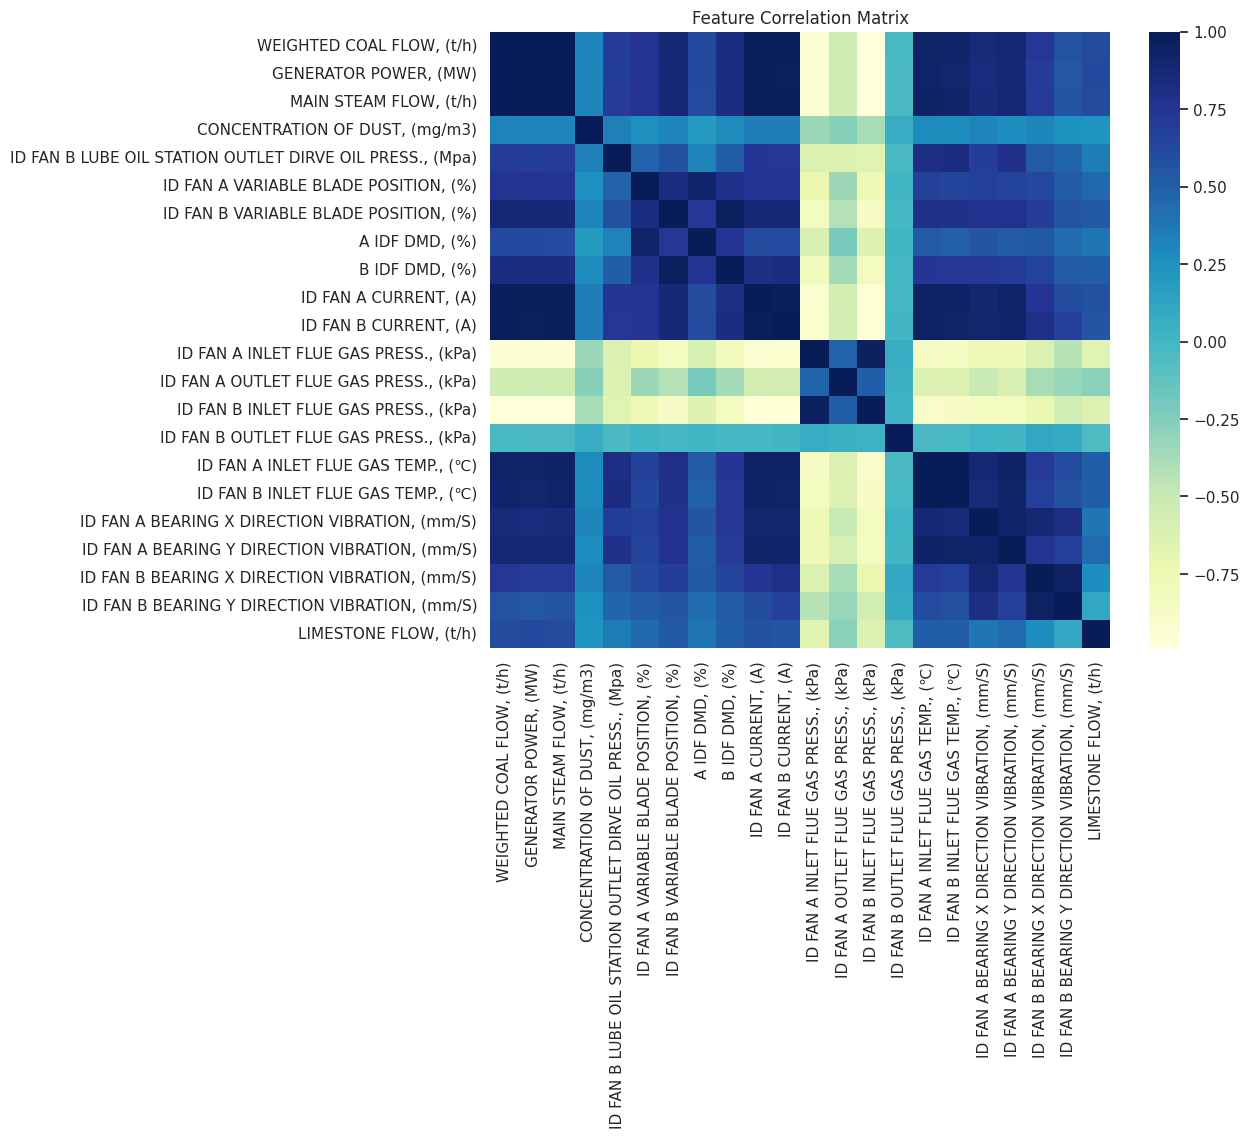

In [5]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
cor = df.corr(numeric_only=True)
sns.heatmap(cor, cmap="YlGnBu", annot=False)
plt.title("Feature Correlation Matrix")
plt.savefig(os.path.join(EDA_PATH, "correlation_heatmap.png"), dpi=300, bbox_inches="tight")
plt.show()

### 1.2 Target Labeling

We know that a machine failure occurred on 2 September 2024 at 10:30

To create the class labels, we will assign all data points from this timestamp back to 24 hours earlier as **"Towards Failure"**
  
All remaining data points will be labeled as **"Normal"**.


Target Class Distribution:
Target_Class
0    26209
1      144
Name: count, dtype: int64


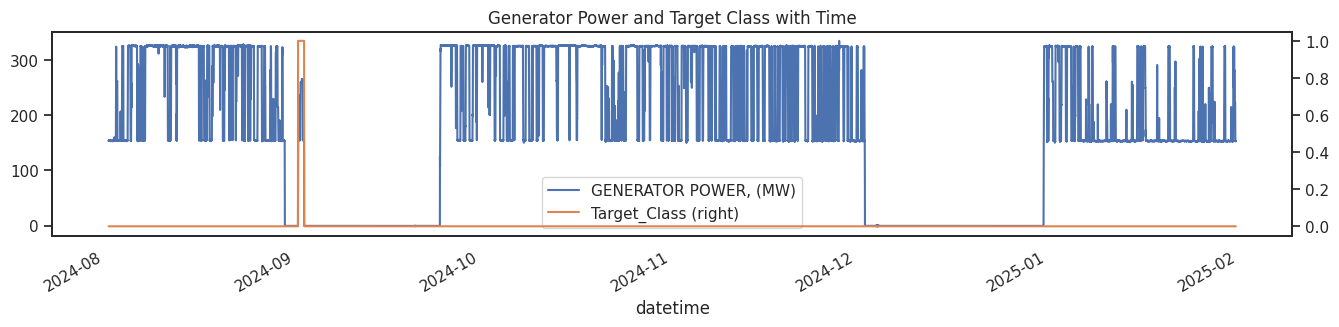

In [6]:
# Define the start and end datetime for "Towards failure"
start_failure = pd.to_datetime('2024-09-01 10:03:00')
end_failure = pd.to_datetime('2024-09-02 10:03:00')

# Create the target_label column
df['Target_Label'] = np.where(
    (df.index >= start_failure) & (df.index <= end_failure), 
    'Towards Failure', 
    'Normal'
)

# Encode Target Column
label_encoder = LabelEncoder()
df['Target_Class'] = label_encoder.fit_transform(df['Target_Label'])

print("Target Class Distribution:")
print(df['Target_Class'].value_counts())

# Visualizing failure with time and Power
#  - Contextual tag for time series visualization
df.plot(
    y=["GENERATOR POWER, (MW)", "Target_Class"],
    secondary_y="Target_Class",
    figsize=(16, 3),
    title="Generator Power and Target Class with Time"
)
plt.savefig(os.path.join(EDA_PATH, "power_and_target_class.png"), dpi=300, bbox_inches="tight")
plt.show()


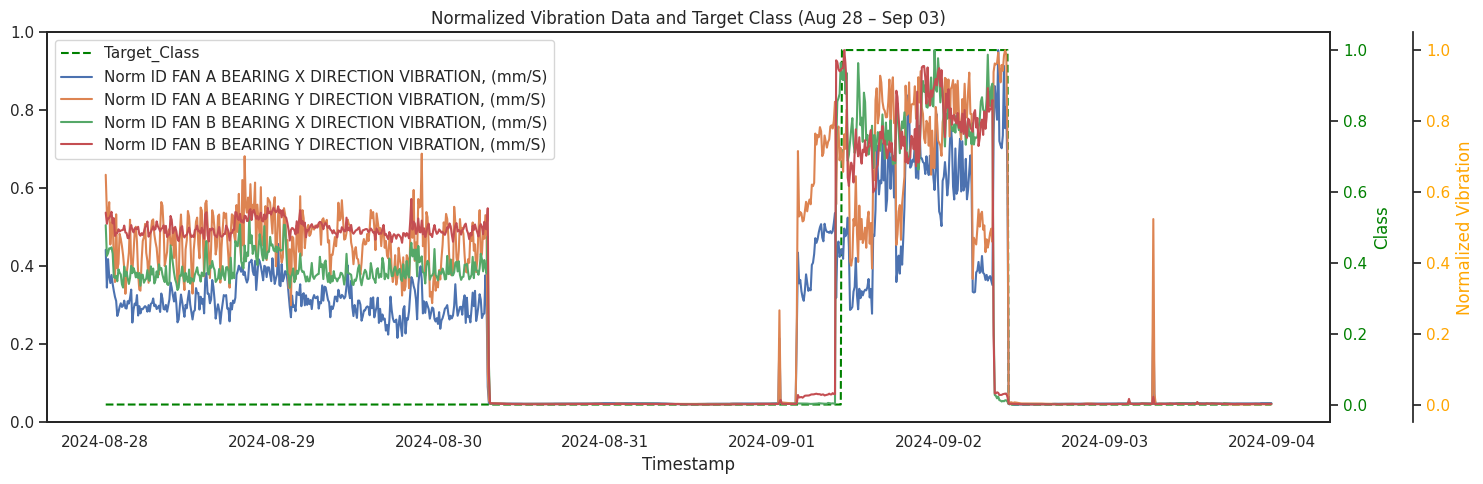

In [7]:
# Filter data between local region
start_date_vis = '2024-08-28'
end_date_vis = '2024-09-03'
df_filtered = df.loc[start_date_vis:end_date_vis].copy() # use .copy()

# Normalize vibration columns using Min-Max scaling
vib_scaler = MinMaxScaler()
vib_columns = [
    'ID FAN A BEARING X DIRECTION VIBRATION, (mm/S)',
    'ID FAN A BEARING Y DIRECTION VIBRATION, (mm/S)',
    'ID FAN B BEARING X DIRECTION VIBRATION, (mm/S)',
    'ID FAN B BEARING Y DIRECTION VIBRATION, (mm/S)'
]

df_filtered[vib_columns] = vib_scaler.fit_transform(df_filtered[vib_columns])

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set_xlabel('Timestamp')

# Second y-axis for the target label
ax2 = ax1.twinx()
line2 = ax2.plot(df_filtered.index, df_filtered['Target_Class'], color='green', label='Target_Class', linestyle='dashed')
ax2.set_ylabel('Class', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Third y-axis for vibration data
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
lines3 = []

# Plot vibration columns
for vib_col in vib_columns:
    l, = ax3.plot(df_filtered.index, df_filtered[vib_col], label=f'Norm {vib_col}')
    lines3.append(l)

ax3.set_ylabel('Normalized Vibration', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Title and combined legend
plt.title('Normalized Vibration Data and Target Class (Aug 28 – Sep 03)')
lines = line2 + lines3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(EDA_PATH, "normalized_vibration_and_target_class.png"), dpi=300, bbox_inches="tight")
plt.show()

 === Correlation values with Target_Class ===
Target_Class                                                1.000000
ID FAN B OUTLET FLUE GAS PRESS., (kPa)                      0.436462
ID FAN B BEARING X DIRECTION VIBRATION, (mm/S)              0.279582
ID FAN B BEARING Y DIRECTION VIBRATION, (mm/S)              0.243864
ID FAN A BEARING X DIRECTION VIBRATION, (mm/S)              0.221713
ID FAN A BEARING Y DIRECTION VIBRATION, (mm/S)              0.158849
CONCENTRATION OF DUST, (mg/m3)                              0.101134
ID FAN A CURRENT, (A)                                       0.093031
ID FAN A VARIABLE BLADE POSITION, (%)                       0.090527
ID FAN B CURRENT, (A)                                       0.083795
A IDF DMD, (%)                                              0.082072
ID FAN B VARIABLE BLADE POSITION, (%)                       0.081672
B IDF DMD, (%)                                              0.079184
ID FAN B INLET FLUE GAS TEMP., (℃)                       

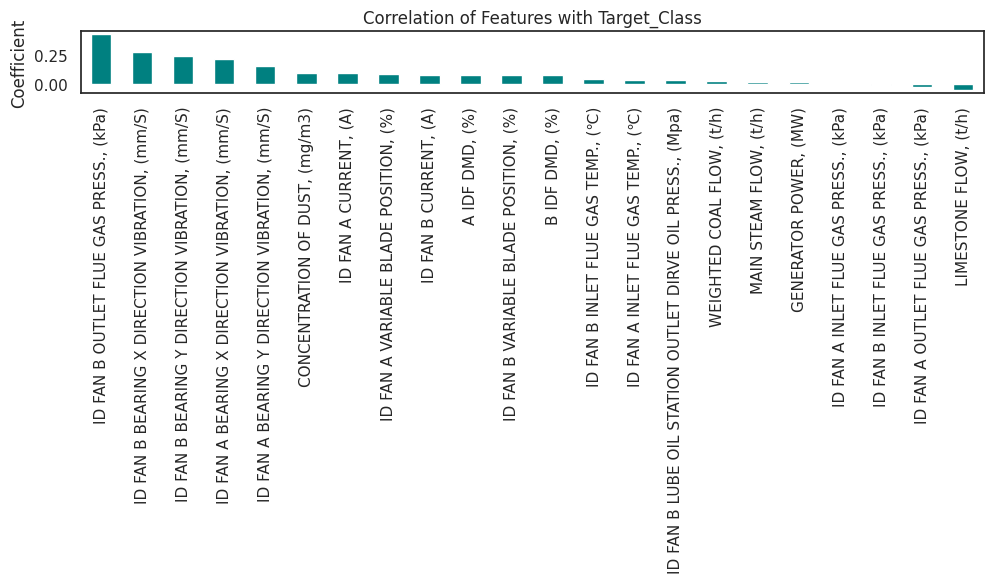

In [8]:
# Feature Correlation with Target

# Select only numeric columns from the dataframe
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric features
target_corr = numeric_df.corr()['Target_Class'].sort_values(ascending=False)

print(" === Correlation values with Target_Class ===")
print(target_corr)

target_corr.drop('Target_Class').plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('Correlation of Features with Target_Class')
plt.ylabel('Coefficient')
plt.tight_layout()
plt.savefig(os.path.join(EDA_PATH, "correlation_with_target_class.png"), dpi=300, bbox_inches="tight")
plt.show()

# Save processed data
df.to_csv(os.path.join(OUTPUT_PATH, 'processed_id_fan_data.csv'), index=True)

### 1.3 Data Splitting

In [9]:
df = df.sort_index()

# Create masks
failure_mask = (df.index >= start_failure) & (df.index <= end_failure)
normal_mask = ~failure_mask

# Split failure region (50% Train, 50% Test)
failure_df = df[failure_mask]
half_fail = len(failure_df) // 2
failure_train = failure_df.iloc[:half_fail]
failure_test = failure_df.iloc[half_fail:]

# Split normal region 
normal_df = df[normal_mask]
split_idx = int(len(normal_df) * TRAIN_RATIO)
normal_train = normal_df.iloc[:split_idx]
normal_test = normal_df.iloc[split_idx:]

# Combine to form final datasets, shuffle the data
train_df = pd.concat([normal_train, failure_train]).sort_index()
test_df = pd.concat([normal_test, failure_test]).sort_index()

# Define Features (X) and Target (y)
cols_to_drop = ['Target_Class', 'Target_Label', 'GENERATOR POWER, (MW)']

X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df['Target_Class']
X_test = test_df.drop(columns=cols_to_drop)
y_test = test_df['Target_Class']

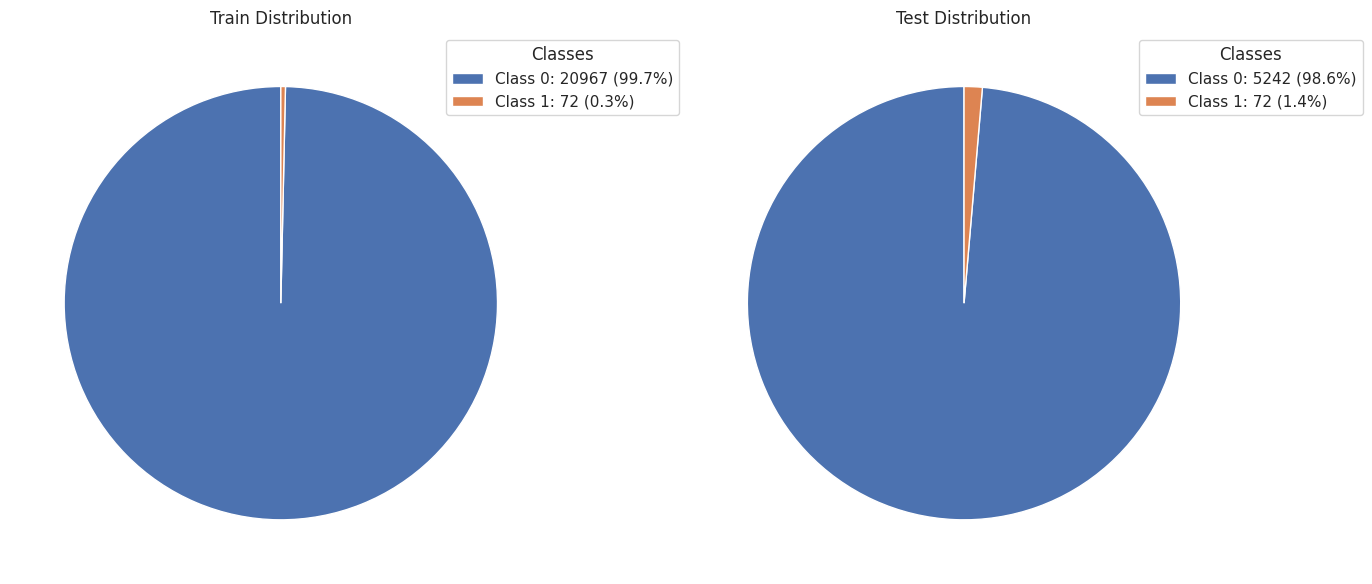

In [10]:
# value counts
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

def make_pie(ax, counts, title):
    wedges, _ = ax.pie(
        counts,
        startangle=90
    )
    
    # create legend entries with counts + percentages
    total = counts.sum()
    labels = [
        f"Class {cls}: {cnt} ({cnt/total*100:.1f}%)"
        for cls, cnt in counts.items()
    ]
    
    ax.legend(wedges, labels, title="Classes", loc="upper right", bbox_to_anchor=(1.25, 1))
    ax.set_title(title)

make_pie(axs[0], train_counts, "Train Distribution")
make_pie(axs[1], test_counts, "Test Distribution")

plt.tight_layout()
plt.savefig(os.path.join(CKPT_PATH, "train_and_test_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Shape: {X_train_scaled.shape}")
print(f"Testing Shape: {X_test_scaled.shape}")

Training Shape: (21039, 21)
Testing Shape: (5314, 21)


## Modeling


### 1.1 Model Selection

In [12]:
# Calculate class imbalance ratio (only used for XGBoost)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED),
    "SVM (RBF)": SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=SEED),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=SEED),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=SEED, verbose=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=SEED)
}

## Model Training and Evaluation

In [13]:
results = []
roc_data, cm_data, report_data = {}, {}, {}

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    # store cm
    cm_data[name] = confusion_matrix(y_test, y_pred)

    # store ROC Data
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_data[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "y_true": y_test,
        "y_score": y_prob
    }

    # store classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_data[name] = report

    # Save the models
    filenames = os.path.join(CKPT_PATH, f"{name.replace(' ', '_')}.joblib")
    joblib.dump(model, filenames)
    print(f"Saved {name} to {filenames}")


# Save scaler
scaler_path = os.path.join(CKPT_PATH, "scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"Saved scaler to {scaler_path}")

# Save test dataset
test_df.to_csv(os.path.join(OUTPUT_PATH, "test_dataset.csv"), index=True)
print(f"Saved test dataset to {os.path.join(OUTPUT_PATH, 'test_dataset.csv')}")

Saved Logistic Regression to ../output/ckpts/Logistic_Regression.joblib
Saved Random Forest to ../output/ckpts/Random_Forest.joblib
Saved SVM (RBF) to ../output/ckpts/SVM_(RBF).joblib
Saved KNN to ../output/ckpts/KNN.joblib
Saved MLP (Neural Net) to ../output/ckpts/MLP_(Neural_Net).joblib
Saved XGBoost to ../output/ckpts/XGBoost.joblib
Saved LightGBM to ../output/ckpts/LightGBM.joblib
Saved Extra Trees to ../output/ckpts/Extra_Trees.joblib
Saved scaler to ../output/ckpts/scaler.joblib
Saved test dataset to ../output/test_dataset.csv


In [14]:
# Display Results Table
results_df = pd.DataFrame(results).round(3).sort_values(by="F1 Score", ascending=False)
results_df.to_csv(os.path.join(OUTPUT_PATH, "results.csv"), index=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.998,1.0,0.819,0.901
1,Random Forest,0.998,1.0,0.819,0.901
2,SVM (RBF),0.998,1.0,0.819,0.901
3,KNN,0.998,1.0,0.819,0.901
5,XGBoost,0.998,1.0,0.819,0.901
6,LightGBM,0.998,1.0,0.819,0.901
7,Extra Trees,0.998,1.0,0.819,0.901
4,MLP (Neural Net),0.997,1.0,0.792,0.884


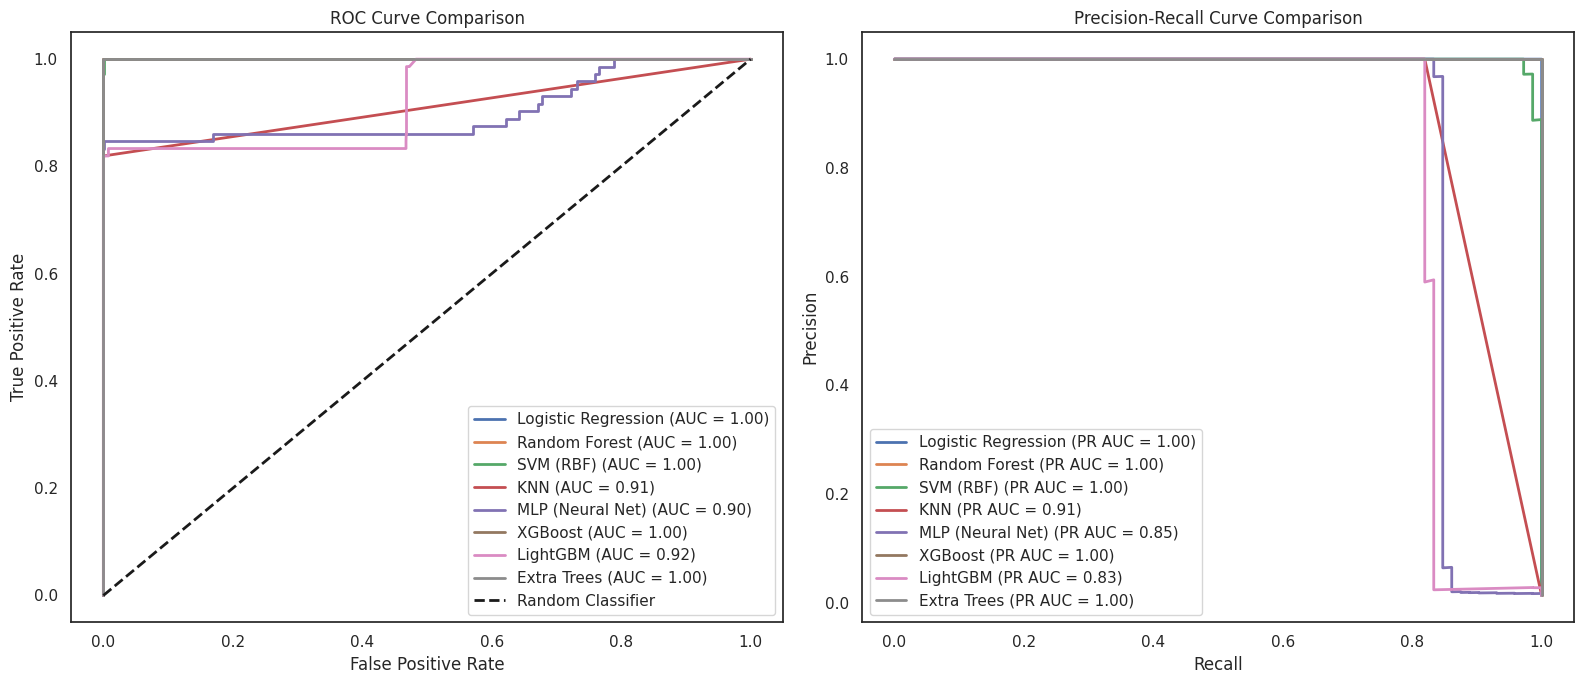

In [15]:
# Visualize ROC, and PR Curves
# Read more about PR Curve here: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
# Usefull when you have a potentially imbalanced dataset like this one
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ROC Curve
for name, data in roc_data.items():
    axes[0].plot(data["fpr"], data["tpr"], lw=2, label=f'{name} (AUC = {data["roc_auc"]:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve Comparison')
axes[0].legend(loc="lower right")

# PR Curve
for name, data in roc_data.items():
    precision, recall, _ = precision_recall_curve(data["y_true"], data["y_score"])
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, lw=2, label=f'{name} (PR AUC = {pr_auc:.2f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve Comparison')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.savefig(os.path.join(CKPT_PATH, "roc_pr_curves.png"), dpi=300, bbox_inches="tight")
plt.show()


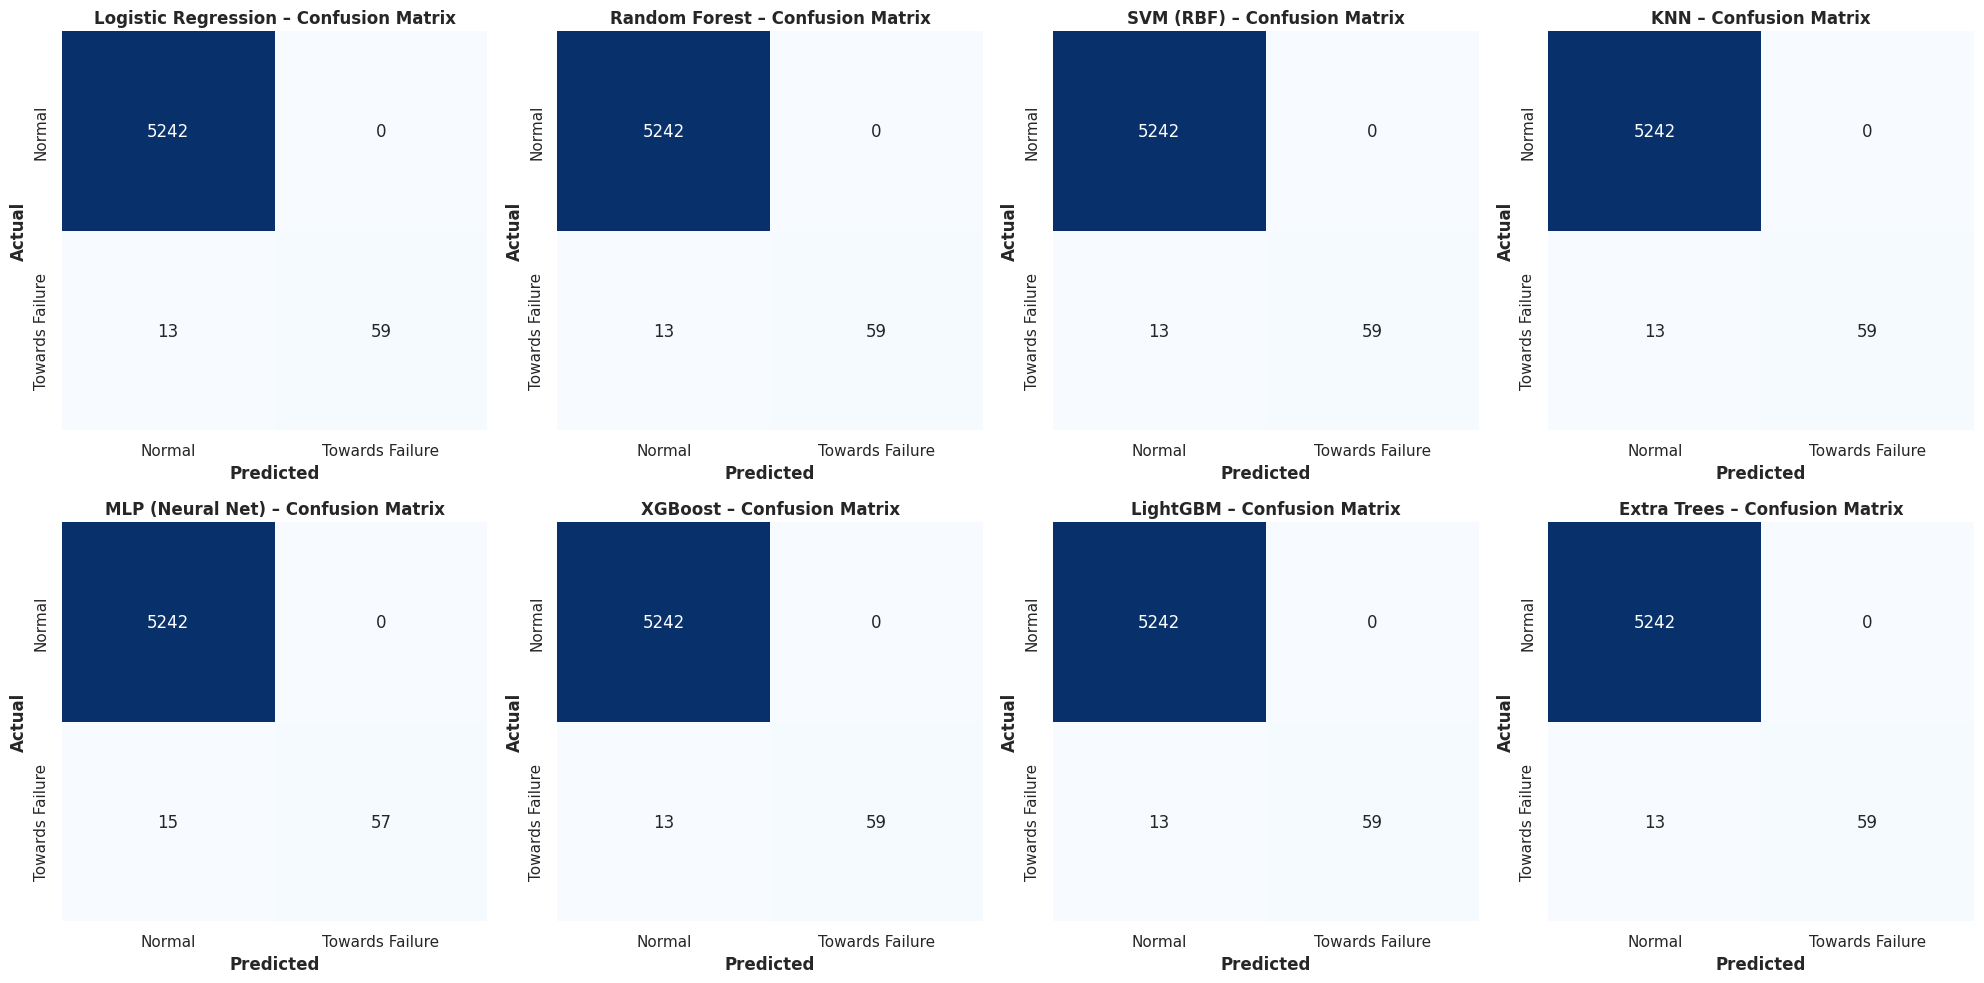

In [16]:
# B. Confusion Matrix Subplots, display labels as Normal and Towards Failure
num_models = len(cm_data)
cols = 4  # Number of columns in the grid
rows = (num_models + cols - 1) // cols
class_names = ['Normal', 'Towards Failure']

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, (name, cm) in enumerate(cm_data.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f"{name} – Confusion Matrix", fontweight="bold")
    axes[i].set_xlabel("Predicted", fontweight="bold")
    axes[i].set_ylabel("Actual", fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(CKPT_PATH, "confusion_matrix.png"), dpi=300, bbox_inches="tight")
plt.show()

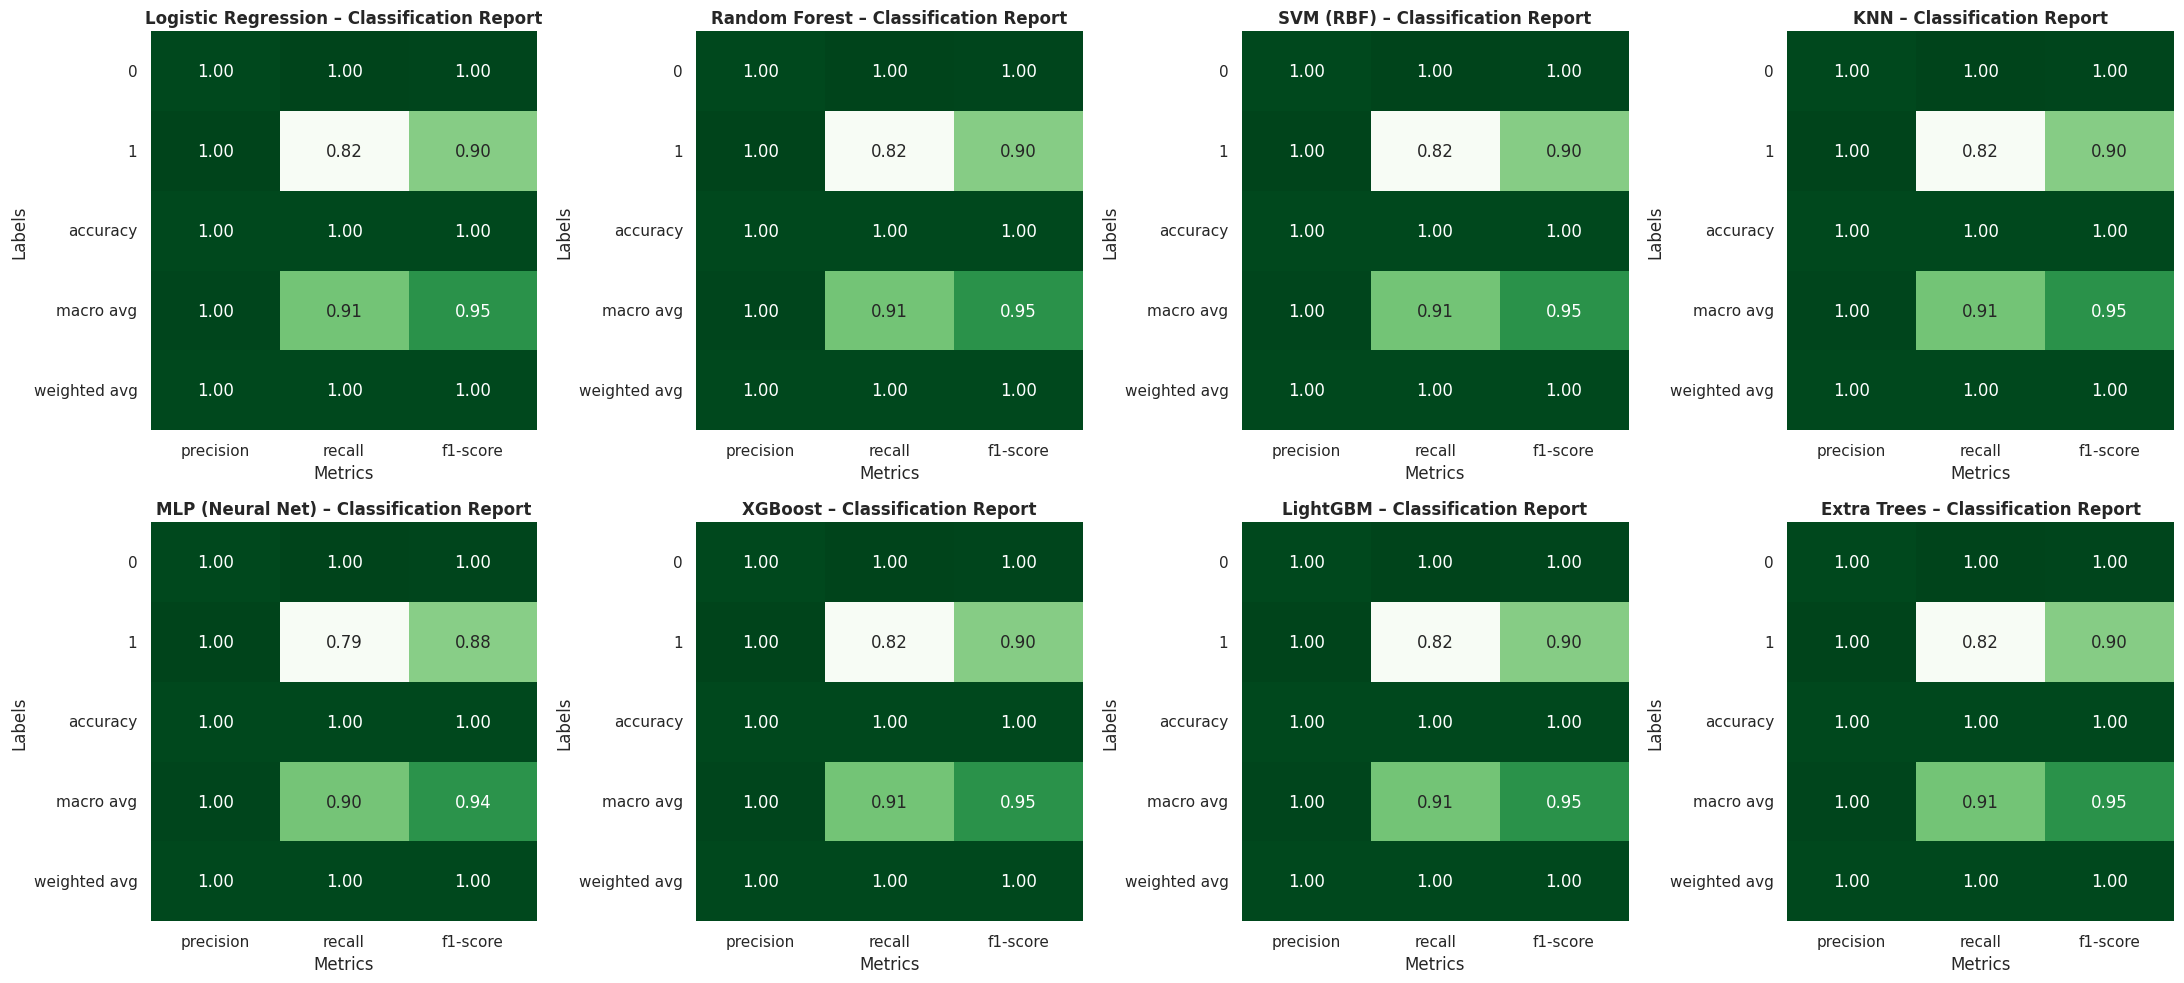

In [17]:
all_rep = {}

for name, report in report_data.items():
    df_rep = pd.DataFrame(report).transpose()
    # only precision, recall, f1-score
    df_rep = df_rep[['precision', 'recall', 'f1-score']]
    
    all_rep[name] = df_rep

fig, axes = plt.subplots(rows, cols, figsize=(22, 5 * rows))
axes = axes.flatten()
for i, (name, df_rep) in enumerate(all_rep.items()):
    heatmap = sns.heatmap(df_rep, annot=True, fmt=".2f", cmap="Greens", ax=axes[i], cbar=False)
    axes[i].set_title(f"{name} – Classification Report", fontweight="bold")
    axes[i].set_xlabel("Metrics")
    axes[i].set_ylabel("Labels")


plt.tight_layout()
plt.savefig(os.path.join(CKPT_PATH, "classification_report.png"), dpi=300, bbox_inches="tight")
plt.show()
